In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import optimizers
from tensorflow.keras import layers

import numpy as np
np.set_printoptions(threshold=10000)
import matplotlib.pyplot as plt
import pandas as pd
pd.options.display.float_format = '{:,.5f}'.format
import scipy as sp
from scipy import stats
import seaborn as sns
import sklearn

from numpy.random import seed
seed(1)
tf.random.set_seed(2)

import time

In [2]:
#CSN_path = './'
CSN_path = './Data/'

def load_CSN_data():
    csv_path = CSN_path + "Master_List_LCPLCP.csv"
    return pd.read_csv(csv_path)

CSN = load_CSN_data()

CSN_new_err = CSN['Error'][-18:]

CSN = CSN.drop(['Example ID', 'Source', 'Figure ID', 'Data Provider', 'PI',
       'Date Received', 'Data Measurment Published', 'Prior Exposure', 'Comments', 'Error'], axis=1)

tsize = CSN.shape[0]//10

CSN_new = pd.get_dummies(CSN)

CSN_new['Surface Area per Liter'] = CSN_new['Surface Area (NMC) (m2/g)'] * CSN_new['Concentration (mg/L)']
CSN_new = CSN_new.drop(['Surface Area (NMC) (m2/g)'], axis=1)

CSN_new['log Concentration'] = np.log10(CSN_new['Concentration (mg/L)'] + 1e-9)
CSN_new = CSN_new.drop(['Concentration (mg/L)'], axis=1)

CSN_new_A = CSN_new[-18:] #assign the last 18 examples for 18 test cases for a different array

CSN_prepared_B = CSN_new[:-18] # Removing the last 18 
CSN_hold_1 = sklearn.utils.shuffle(CSN_prepared_B, random_state=5946) #shuffling the 206 data examples as Clyde did
tsize1 = CSN_hold_1.shape[0]//10 # decide the size of the test examples which is 20 - clyde did it

CSN_prepared_B = CSN_hold_1[:-tsize1].reset_index(drop=True) #Remove that 20 data examples from the bottom of the list
CSN_test = CSN_hold_1[-tsize1:] # assign that 20 data examples whcih we will use later

In [3]:
def norm(x, train_dataset):
    train_stats = train_dataset.describe().transpose()
    return (x - train_stats['mean']) / train_stats['std'].replace(to_replace=0, value=1)

def build_model(data):
    model = keras.Sequential()
    model.add(keras.layers.Dense(5, activation=keras.layers.ELU(), input_shape=(data.shape[1],)))
    for k in range(3-1):
        model.add(keras.layers.Dense(5, activation=keras.layers.ELU()))
    model.add(keras.layers.Dense(1, activation=keras.layers.ReLU()))
    
    model.compile(loss='mse',
                optimizer=keras.optimizers.Adam(),
                metrics=['mae'])
    
    return model

def plot_mae(history):
    plt.figure()
    plt.xlabel('Training Steps')
    plt.ylabel('Mean Abs Error')
    plt.ylim(0, 1)
    plt.plot(history.epoch, np.array(history.history['mae']),
             label='Train MAE')
    plt.plot(history.epoch, np.array(history.history['val_mae']),
             label = 'Val MAE')
    plt.legend()
    plt.show()
    print(np.array(history.history['mae'])[-1], 
        np.array(history.history['val_mae'])[-1])
    
def plot_loss(history):
    plt.figure()
    plt.xlabel('Training Steps')
    plt.ylabel('Loss')
    plt.ylim(0, 1)
    plt.plot(history.epoch, np.array(history.history['loss']),
             label='Train MAE')
    plt.plot(history.epoch, np.array(history.history['val_loss']),
             label = 'Val MAE')
    plt.legend()
    plt.show()
    print(np.array(history.history['loss'])[-1], 
        np.array(history.history['val_loss'])[-1])
    
def rc(x, y):
    mx = np.mean(x)
    my = np.mean(y)
    sx = np.std(x)
    sy = np.std(y)
    
    zx = (x - mx)/sx
    zy = (y - my)/sy
    
    return np.sum(zx*zy)/(x.size-1)

def non_zero_mean(a, axis=None):
    return np.nanmean(np.where(np.isclose(a,0), np.nan, a), axis=axis)

def non_zero_std(a, axis=None):
    return np.nanstd(np.where(np.isclose(a,0), np.nan, a), axis=axis)

In [4]:
def print_full(x):
    pd.set_option('display.max_rows', x.shape[0])
    if len(x.shape) < 2:
        pd.set_option('display.max_columns', 1)
    else:
        pd.set_option('display.max_columns', x.shape[1])
    return x
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')

corr_matrix = CSN_prepared_B.corr()
print_full(abs(corr_matrix["Viability Fraction "]).sort_values(ascending=False))

Viability Fraction                       1.00000
Particle Shape_Ellipsoid                 0.51176
Type_Carbon Dot                          0.51176
Nitrogen                                 0.50760
Platinum                                 0.50394
Silicon                                  0.36955
Phosphorus                               0.34365
Particle Shape_Sphere                    0.30346
Type_CdSe Core QD                        0.27796
Oxygen                                   0.25275
Capping Agent_PAH                        0.23038
Total Comp Knowledge_T                   0.22949
Total Comp Knowledge_F                   0.22949
Capping Agent_None                       0.22894
Method_GVB                               0.22242
Zinc                                     0.21699
Purification Method_None                 0.21659
Type_Nanodiamond                         0.21537
Cadmium                                  0.21218
Surface Area per Liter                   0.20445
Selenium            

In [5]:
print_full(CSN_prepared_B)

,Carbon,Nitrogen,Phosphorus,Hydrogen,Titanium,Gold,Lithium,Nickel,Cobalt,Manganese,Oxygen,Cadmium,Selenium,Sulfur,Silicon,Platinum,Zinc,Particle Diameter Dimension 1 (nm),Particle Diameter Dimension 2 (nm),Particle Diameter Dimension 3 (nm),pH,Natural Organic Matter (mg/L),Total Centrifugation Steps,Exposure Time (min),Viability Fraction,Type_Carbon Dot,Type_CdSe Core QD,Type_Gold,Type_LCO,Type_LCP,Type_NMC,Type_Nanodiamond,Type_Titania,Total Comp Knowledge_F,Total Comp Knowledge_T,Capping Agent_MPA,Capping Agent_MPNH2,Capping Agent_None,Capping Agent_PAH,Particle Shape_Amorphous,Particle Shape_Ellipsoid,Particle Shape_Rectangular Prism,Particle Shape_Sheet,Particle Shape_Sphere,Medium_HEPES Buffer,Medium_LB Broth,Medium_Leibovitz’s L-15 media,Medium_MHRW,Medium_Minimal Medium,Purification Method_1 C H2O,"Purification Method_1 C H2O, 4 C MeOH",Purification Method_2 C H2O,"Purification Method_2 C H2O, 3 C MeOH",Purification Method_3 C H2O,Purification Method_Diafiltration,Purification Method_Dialysis,Purification Method_None,Purification Method_Washing,Bacteria_No,Bacteria_Yes,Gram_Negative,Gram_None,Gram_Positive,Identity _Acinetobacter baylyi,Identity _Azotobacter vinelandii,Identity _Bacillus subtilis,Identity _Daphnia magna,Identity _Oncorhynchus mykiss,Identity _Pseudomonas aeruginosa,Identity _Shewanella oneidensis,Mutation_ADP1,Mutation_MR-1,Mutation_MR-4,Mutation_None,Mutation_PAO1,Mutation_RTgill-W1,Mutation_SB 491,Mutation_UW,Mutation_dltA,Mutation_tagE,Method_ATT,Method_CC,Method_GVB,Method_VCA,Surface Area per Liter,log Concentration
0,0.00000,0.00000,0.00000,0,0.00000,1,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,0.00000,0.00000,0.00000,4.80000,4.80000,4.80000,7.40000,0.00000,0,15,0.01357,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0.00000,-1.52288
1,0.00000,0.00000,0.00000,0,0.00000,1,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,0.00000,0.00000,0.00000,4.50000,4.50000,4.50000,7.40000,0.00000,0,15,0.77250,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0.00000,0.69897
2,0.00000,0.00000,0.00000,0,0.00000,0,0.25000,0.14250,0.04750,0.05750,0.50000,0.00000,0.00000,0,0.00000,0.00000,0.00000,750.00000,750.00000,750.00000,7.40000,0.00000,5,172800,1.00000,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,10.00000,1.01954
3,0.00000,0.00000,0.00000,0,0.00000,0,0.25000,0.14250,0.04750,0.05750,0.50000,0.00000,0.00000,0,0.00000,0.00000,0.00000,750.00000,750.00000,750.00000,7.40000,0.00000,5,180,0.69750,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0.35610,-0.42889
4,0.00000,0.00000,0.00000,0,0.00000,1,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,0.00000,0.00000,0.00000,8.90000,8.90000,8.90000,7.40000,0.00000,0,10,0.90410,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0.00000,-4.30102
5,0.00000,0.00000,0.00000,0,0.00000,0,0.25000,0.08000,0.08250,0.08750,0.50000,0.00000,0.00000,0,0.00000,0.00000,0.00000,5.00000,70.00000,70.00000,7.25000,0.00000,5,180,0.29100,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,"12,720.00000",2.00000
6,0.00000,0.00000,0.00000,0,0.00000,0,0.25000,0.08500,0.08250,0.08250,0.50000,0.00000,0.00000,0,0.00000,0.00000,0.00000,5.00000,70.00000,70.00000,7.40000,0.00000,5,0,1.00000,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,2.84900,-1.60221
7,0.00000,0.00000,0.00000,0,0.00000,0,0.00000,0.00000,0.00000,0.00000,0.00000,0.02369,0.00620,0,0.00000,0.00000,0.97011,5.90000,5.90000,5.90000,7.40000,0.00000,0,15,0.00205,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,

In [6]:
train = CSN_prepared_B.sample(frac=3/4, random_state=0)
test = CSN_prepared_B.loc[~CSN_prepared_B.index.isin(train.index), :]

train_f = train.drop(['Viability Fraction '], axis=1)
test_f = test.drop(['Viability Fraction '], axis=1)

ntrain_f = norm(train_f, train_f)
ntrain_l = train['Viability Fraction ']
ntest_f = norm(test_f, train_f)
ntest_l = test['Viability Fraction ']

In [7]:
model = build_model(ntrain_f)

In [8]:
history = model.fit(ntrain_f,
    ntrain_l,
    #checking validation data after each epoch
    validation_data=(ntest_f, ntest_l),
    epochs=1000,
    batch_size=25)

Epoch 1/1000
6/6 [==============================] - 0s 30ms/step - loss: 0.7777 - mae: 0.7620 - val_loss: 0.7625 - val_mae: 0.7699
Epoch 2/1000
6/6 [==============================] - 0s 12ms/step - loss: 0.7499 - mae: 0.7407 - val_loss: 0.7486 - val_mae: 0.7561
Epoch 3/1000
6/6 [==============================] - 0s 11ms/step - loss: 0.7172 - mae: 0.7133 - val_loss: 0.7294 - val_mae: 0.7368
Epoch 4/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.6927 - mae: 0.6932 - val_loss: 0.7132 - val_mae: 0.7179
Epoch 5/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.6657 - mae: 0.6674 - val_loss: 0.7011 - val_mae: 0.7067
Epoch 6/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.6405 - mae: 0.6478 - val_loss: 0.6929 - val_mae: 0.6973
Epoch 7/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.6187 - mae: 0.6296 - val_loss: 0.6853 - val_mae: 0.6901
Epoch 8/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.5950 - m

6/6 [==============================] - 0s 9ms/step - loss: 0.0823 - mae: 0.1725 - val_loss: 0.1173 - val_mae: 0.2479
Epoch 126/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0847 - mae: 0.1744 - val_loss: 0.1200 - val_mae: 0.2515
Epoch 127/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0823 - mae: 0.1721 - val_loss: 0.1167 - val_mae: 0.2441
Epoch 128/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0817 - mae: 0.1716 - val_loss: 0.1161 - val_mae: 0.2407
Epoch 129/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0822 - mae: 0.1730 - val_loss: 0.1144 - val_mae: 0.2369
Epoch 130/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0821 - mae: 0.1724 - val_loss: 0.1160 - val_mae: 0.2404
Epoch 131/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0822 - mae: 0.1727 - val_loss: 0.1157 - val_mae: 0.2405
Epoch 132/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0825 - mae: 0.

6/6 [==============================] - 0s 9ms/step - loss: 0.0786 - mae: 0.1674 - val_loss: 0.1283 - val_mae: 0.2483
Epoch 188/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0771 - mae: 0.1644 - val_loss: 0.1285 - val_mae: 0.2487
Epoch 189/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0773 - mae: 0.1640 - val_loss: 0.1288 - val_mae: 0.2489
Epoch 190/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0778 - mae: 0.1649 - val_loss: 0.1298 - val_mae: 0.2508
Epoch 191/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0768 - mae: 0.1635 - val_loss: 0.1275 - val_mae: 0.2465
Epoch 192/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0770 - mae: 0.1640 - val_loss: 0.1264 - val_mae: 0.2441
Epoch 193/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0769 - mae: 0.1643 - val_loss: 0.1268 - val_mae: 0.2450
Epoch 194/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0775 - mae: 0

Epoch 249/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0711 - mae: 0.1549 - val_loss: 0.1355 - val_mae: 0.2495
Epoch 250/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0708 - mae: 0.1545 - val_loss: 0.1355 - val_mae: 0.2501
Epoch 251/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0706 - mae: 0.1549 - val_loss: 0.1348 - val_mae: 0.2495
Epoch 252/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0708 - mae: 0.1546 - val_loss: 0.1357 - val_mae: 0.2500
Epoch 253/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0701 - mae: 0.1545 - val_loss: 0.1369 - val_mae: 0.2504
Epoch 254/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0709 - mae: 0.1552 - val_loss: 0.1379 - val_mae: 0.2506
Epoch 255/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0705 - mae: 0.1537 - val_loss: 0.1363 - val_mae: 0.2482
Epoch 256/1000
6/6 [==============================] - 0s 11ms/step - 

Epoch 311/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0664 - mae: 0.1483 - val_loss: 0.1499 - val_mae: 0.2569
Epoch 312/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0663 - mae: 0.1478 - val_loss: 0.1522 - val_mae: 0.2596
Epoch 313/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0670 - mae: 0.1486 - val_loss: 0.1502 - val_mae: 0.2581
Epoch 314/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0662 - mae: 0.1475 - val_loss: 0.1499 - val_mae: 0.2578
Epoch 315/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0662 - mae: 0.1469 - val_loss: 0.1498 - val_mae: 0.2583
Epoch 316/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0666 - mae: 0.1490 - val_loss: 0.1479 - val_mae: 0.2569
Epoch 317/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0662 - mae: 0.1482 - val_loss: 0.1485 - val_mae: 0.2570
Epoch 318/1000
6/6 [==============================] - 0s 9ms/step - loss: 0

Epoch 373/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0648 - mae: 0.1446 - val_loss: 0.1572 - val_mae: 0.2580
Epoch 374/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0646 - mae: 0.1445 - val_loss: 0.1529 - val_mae: 0.2555
Epoch 375/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0647 - mae: 0.1445 - val_loss: 0.1540 - val_mae: 0.2563
Epoch 376/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0645 - mae: 0.1437 - val_loss: 0.1559 - val_mae: 0.2567
Epoch 377/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0646 - mae: 0.1441 - val_loss: 0.1561 - val_mae: 0.2567
Epoch 378/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0648 - mae: 0.1446 - val_loss: 0.1585 - val_mae: 0.2577
Epoch 379/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0649 - mae: 0.1430 - val_loss: 0.1589 - val_mae: 0.2577
Epoch 380/1000
6/6 [==============================] - 0s 9ms/step - loss: 

Epoch 435/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0632 - mae: 0.1396 - val_loss: 0.1600 - val_mae: 0.2575
Epoch 436/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0644 - mae: 0.1401 - val_loss: 0.1628 - val_mae: 0.2598
Epoch 437/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0629 - mae: 0.1385 - val_loss: 0.1582 - val_mae: 0.2554
Epoch 438/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0627 - mae: 0.1404 - val_loss: 0.1570 - val_mae: 0.2533
Epoch 439/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0648 - mae: 0.1442 - val_loss: 0.1613 - val_mae: 0.2562
Epoch 440/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0638 - mae: 0.1426 - val_loss: 0.1589 - val_mae: 0.2550
Epoch 441/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0632 - mae: 0.1396 - val_loss: 0.1656 - val_mae: 0.2593
Epoch 442/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.

Epoch 497/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0614 - mae: 0.1354 - val_loss: 0.1615 - val_mae: 0.2577
Epoch 498/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0619 - mae: 0.1364 - val_loss: 0.1586 - val_mae: 0.2559
Epoch 499/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0630 - mae: 0.1384 - val_loss: 0.1675 - val_mae: 0.2630
Epoch 500/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0613 - mae: 0.1344 - val_loss: 0.1676 - val_mae: 0.2636
Epoch 501/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0619 - mae: 0.1361 - val_loss: 0.1643 - val_mae: 0.2607
Epoch 502/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0616 - mae: 0.1342 - val_loss: 0.1630 - val_mae: 0.2595
Epoch 503/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0614 - mae: 0.1362 - val_loss: 0.1597 - val_mae: 0.2574
Epoch 504/1000
6/6 [==============================] - 0s 9ms/step - loss: 0

Epoch 559/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0601 - mae: 0.1317 - val_loss: 0.1666 - val_mae: 0.2628
Epoch 560/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0603 - mae: 0.1324 - val_loss: 0.1649 - val_mae: 0.2614
Epoch 561/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0598 - mae: 0.1328 - val_loss: 0.1645 - val_mae: 0.2603
Epoch 562/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0600 - mae: 0.1325 - val_loss: 0.1654 - val_mae: 0.2609
Epoch 563/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0611 - mae: 0.1330 - val_loss: 0.1682 - val_mae: 0.2637
Epoch 564/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0596 - mae: 0.1322 - val_loss: 0.1650 - val_mae: 0.2609
Epoch 565/1000
6/6 [==============================] - 0s 12ms/step - loss: 0.0623 - mae: 0.1391 - val_loss: 0.1622 - val_mae: 0.2579
Epoch 566/1000
6/6 [==============================] - 0s 10ms/step - loss:

Epoch 621/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0590 - mae: 0.1296 - val_loss: 0.1653 - val_mae: 0.2592
Epoch 622/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0591 - mae: 0.1305 - val_loss: 0.1683 - val_mae: 0.2619
Epoch 623/1000
6/6 [==============================] - 0s 11ms/step - loss: 0.0592 - mae: 0.1336 - val_loss: 0.1672 - val_mae: 0.2617
Epoch 624/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0600 - mae: 0.1341 - val_loss: 0.1695 - val_mae: 0.2627
Epoch 625/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0584 - mae: 0.1289 - val_loss: 0.1695 - val_mae: 0.2630
Epoch 626/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0580 - mae: 0.1296 - val_loss: 0.1675 - val_mae: 0.2601
Epoch 627/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0588 - mae: 0.1313 - val_loss: 0.1722 - val_mae: 0.2637
Epoch 628/1000
6/6 [==============================] - 0s 9ms/step - loss

Epoch 683/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0576 - mae: 0.1269 - val_loss: 0.1770 - val_mae: 0.2622
Epoch 684/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0563 - mae: 0.1262 - val_loss: 0.1810 - val_mae: 0.2657
Epoch 685/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0572 - mae: 0.1258 - val_loss: 0.1803 - val_mae: 0.2674
Epoch 686/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0563 - mae: 0.1258 - val_loss: 0.1789 - val_mae: 0.2675
Epoch 687/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0565 - mae: 0.1250 - val_loss: 0.1789 - val_mae: 0.2676
Epoch 688/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0565 - mae: 0.1262 - val_loss: 0.1800 - val_mae: 0.2694
Epoch 689/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0564 - mae: 0.1261 - val_loss: 0.1811 - val_mae: 0.2697
Epoch 690/1000
6/6 [==============================] - 0s 10ms/step - loss:

Epoch 745/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0555 - mae: 0.1231 - val_loss: 0.1897 - val_mae: 0.2689
Epoch 746/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0538 - mae: 0.1213 - val_loss: 0.1892 - val_mae: 0.2718
Epoch 747/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0551 - mae: 0.1252 - val_loss: 0.1883 - val_mae: 0.2702
Epoch 748/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0551 - mae: 0.1283 - val_loss: 0.1843 - val_mae: 0.2657
Epoch 749/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0547 - mae: 0.1237 - val_loss: 0.1881 - val_mae: 0.2690
Epoch 750/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0563 - mae: 0.1261 - val_loss: 0.1896 - val_mae: 0.2700
Epoch 751/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0550 - mae: 0.1244 - val_loss: 0.1878 - val_mae: 0.2664
Epoch 752/1000
6/6 [==============================] - 0s 10ms/step - loss

Epoch 807/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0532 - mae: 0.1192 - val_loss: 0.1947 - val_mae: 0.2702
Epoch 808/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0529 - mae: 0.1199 - val_loss: 0.1926 - val_mae: 0.2677
Epoch 809/1000
6/6 [==============================] - 0s 11ms/step - loss: 0.0528 - mae: 0.1197 - val_loss: 0.1951 - val_mae: 0.2714
Epoch 810/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0528 - mae: 0.1195 - val_loss: 0.1961 - val_mae: 0.2713
Epoch 811/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0535 - mae: 0.1213 - val_loss: 0.1929 - val_mae: 0.2669
Epoch 812/1000
6/6 [==============================] - 0s 11ms/step - loss: 0.0530 - mae: 0.1195 - val_loss: 0.1934 - val_mae: 0.2667
Epoch 813/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0532 - mae: 0.1196 - val_loss: 0.1962 - val_mae: 0.2697
Epoch 814/1000
6/6 [==============================] - 0s 9ms/step - los

Epoch 869/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0524 - mae: 0.1215 - val_loss: 0.1902 - val_mae: 0.2581
Epoch 870/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0523 - mae: 0.1203 - val_loss: 0.1948 - val_mae: 0.2678
Epoch 871/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0541 - mae: 0.1224 - val_loss: 0.1947 - val_mae: 0.2705
Epoch 872/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0524 - mae: 0.1223 - val_loss: 0.1948 - val_mae: 0.2689
Epoch 873/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0523 - mae: 0.1208 - val_loss: 0.1936 - val_mae: 0.2658
Epoch 874/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0520 - mae: 0.1180 - val_loss: 0.1914 - val_mae: 0.2612
Epoch 875/1000
6/6 [==============================] - 0s 12ms/step - loss: 0.0529 - mae: 0.1196 - val_loss: 0.1916 - val_mae: 0.2633
Epoch 876/1000
6/6 [==============================] - 0s 9ms/step - los

Epoch 931/1000
6/6 [==============================] - 0s 11ms/step - loss: 0.0514 - mae: 0.1181 - val_loss: 0.1926 - val_mae: 0.2656
Epoch 932/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0512 - mae: 0.1190 - val_loss: 0.1917 - val_mae: 0.2609
Epoch 933/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0505 - mae: 0.1174 - val_loss: 0.1913 - val_mae: 0.2607
Epoch 934/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0509 - mae: 0.1172 - val_loss: 0.1910 - val_mae: 0.2605
Epoch 935/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0507 - mae: 0.1165 - val_loss: 0.1893 - val_mae: 0.2586
Epoch 936/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0508 - mae: 0.1156 - val_loss: 0.1913 - val_mae: 0.2595
Epoch 937/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0517 - mae: 0.1169 - val_loss: 0.1942 - val_mae: 0.2619
Epoch 938/1000
6/6 [==============================] - 0s 10ms/step - los

Epoch 993/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0502 - mae: 0.1165 - val_loss: 0.1920 - val_mae: 0.2582
Epoch 994/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0498 - mae: 0.1158 - val_loss: 0.1927 - val_mae: 0.2584
Epoch 995/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0495 - mae: 0.1152 - val_loss: 0.1926 - val_mae: 0.2579
Epoch 996/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0505 - mae: 0.1158 - val_loss: 0.1909 - val_mae: 0.2568
Epoch 997/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0504 - mae: 0.1160 - val_loss: 0.1906 - val_mae: 0.2599
Epoch 998/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0517 - mae: 0.1178 - val_loss: 0.1937 - val_mae: 0.2630
Epoch 999/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0517 - mae: 0.1178 - val_loss: 0.1883 - val_mae: 0.2590
Epoch 1000/1000
6/6 [==============================] - 0s 9ms/step - loss:

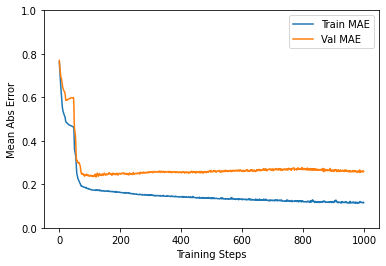

0.11506324261426926 0.25832322239875793


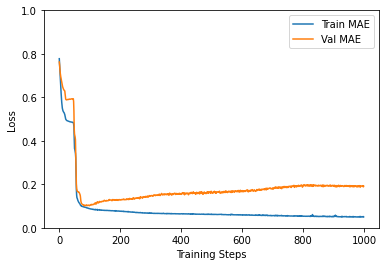

0.050018493086099625 0.19129298627376556


In [9]:
plot_mae(history)

plot_loss(history)

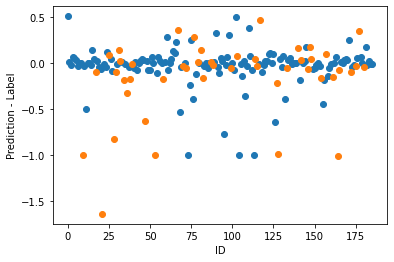

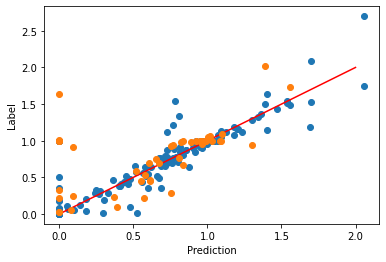

In [10]:
y = model.predict(ntrain_f).flatten() - ntrain_l.values
x = ntrain_l.index

plt.figure()
plt.ylabel('Prediction - Label')
plt.xlabel('ID')
plt.plot(x, y, 'C0o')

y = model.predict(ntest_f).flatten() - ntest_l.values
x = ntest_l.index

plt.plot(x, y, 'C1o')
plt.show()

y = ntrain_l.values
x = model.predict(ntrain_f).flatten()

plt.figure()
plt.plot(x, y, 'C0o')
plt.plot((0, 2), (0, 2), 'r')
plt.xlabel('Prediction')
plt.ylabel('Label')

y = ntest_l.values
x = model.predict(ntest_f).flatten()

plt.plot(x, y, 'C1o')
plt.show()

0.6507504621923108


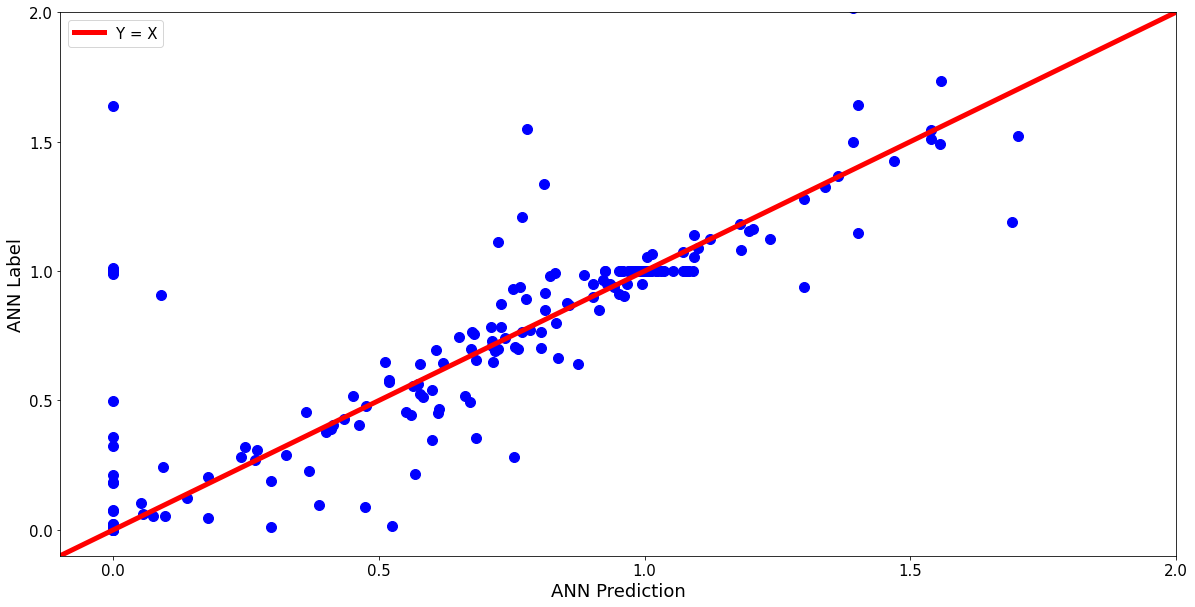

<Figure size 432x288 with 0 Axes>

In [11]:
nCSN_prepared = norm(CSN_prepared_B.drop(['Viability Fraction '], axis=1), train_f)

#model = build_model(nCSN_prepared)

#history = model.fit(nCSN_prepared, CSN_prepared['Viability Fraction '], epochs=1000, batch_size=8, verbose=0)

print(rc(model.predict(nCSN_prepared).flatten(), CSN_prepared_B['Viability Fraction '])**2)

ann_pred = plt.figure(figsize=(20,10))
plt.plot(model.predict(nCSN_prepared), CSN_prepared_B['Viability Fraction '], 
        'bo', label=None, markersize=10)
plt.plot((-1, 2), (-1, 2), 'r', label='Y = X', linewidth=5)
plt.legend(fontsize=15)
plt.xlabel('ANN Prediction', fontsize=18)
plt.ylabel('ANN Label', fontsize=18)
plt.xticks([0., 0.5, 1., 1.5, 2.], fontsize=15)
plt.yticks([0., 0.5, 1., 1.5, 2.], fontsize=15)
plt.ylim(-.1, 2)
plt.xlim(-.1, 2)
plt.show()

plt.draw()
#ann_pred.savefig('Figures/ann_pred.eps', format='eps')

-0.028367031792021657 0.22056999717193732 0.018486758805723404 0.0
-0.14797516002072109 0.4373705684780805 0.060683850402987786 -0.046018242835998535


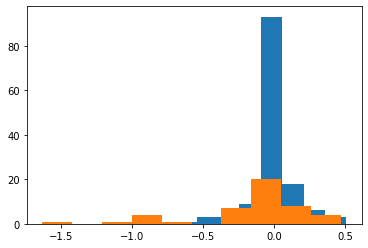

In [12]:
y = model.predict(ntrain_f).flatten() - ntrain_l.values

plt.hist(y)

print(np.mean(y), np.sqrt(np.mean(y**2)), np.std(y)/np.sqrt(y.size), np.median(y))

y = model.predict(ntest_f).flatten() - ntest_l.values

plt.hist(y)

print(np.mean(y), np.sqrt(np.mean(y**2)), np.std(y)/np.sqrt(y.size), np.median(y))

In [13]:
#rewriting code to be better and smarter
#goal - train a large number of machines with 1:3 splits of the data
#have them predict on ALL the data
#save the results separated into train and test

modelnum = 100

train_v = np.zeros((CSN_prepared_B.shape[0], modelnum))
num_train_v = np.zeros((CSN_prepared_B.shape[0]))
test_v = np.zeros((CSN_prepared_B.shape[0], modelnum))
num_test_v = np.zeros((CSN_prepared_B.shape[0]))

start_time = time.time()

for i in range(modelnum):
        
    train = CSN_prepared_B.sample(frac=3/4, random_state=i)
    test = CSN_prepared_B.loc[~CSN_prepared_B.index.isin(train.index), :]
    
    train_index = train.index
    test_index = test.index
    
    train_f = train.drop(['Viability Fraction '], axis=1)
    test_f = test.drop(['Viability Fraction '], axis=1)
    
    ntrain_f = norm(train_f, train_f)
    ntrain_l = train['Viability Fraction ']
    ntest_f = norm(test_f, train_f)
    ntest_l = test['Viability Fraction ']
    
    nall_f = norm(CSN_prepared_B.drop(['Viability Fraction '], axis=1), train_f)
    
    tf.keras.backend.clear_session()
    np.random.seed(i)
    tf.random.set_seed(i)
    model = build_model(ntrain_f)
    
    history = model.fit(ntrain_f,
    ntrain_l,
    #checsamping validation data after each epoch
    validation_data=(ntest_f, ntest_l),
    epochs=1000,
    batch_size=25,
    verbose = 0
    )
    
    pred = model.predict(nall_f).flatten()
    
    train_v[train_index, i] += pred[train_index] 
    num_train_v[train_index] += 1
    test_v[test_index, i] += pred[test_index] 
    num_test_v[test_index] += 1
    
    elapsed_time = time.time() - start_time
    print(i, elapsed_time)

0 56.34729790687561
1 113.84147191047668
2 171.90400576591492
3 228.92169380187988
4 288.40969800949097
5 346.0301659107208
6 403.6551208496094
7 459.51377296447754
8 515.1456627845764
9 570.8739557266235
10 626.4649918079376
11 682.1076428890228
12 737.7151019573212
13 793.3968517780304
14 848.9969546794891
15 905.6862368583679
16 961.5274670124054
17 1017.2588820457458
18 1072.9422278404236
19 1128.6660149097443
20 1184.3397488594055
21 1240.0553939342499
22 1295.6867036819458
23 1351.4206109046936
24 1407.2590646743774
25 1463.1520459651947
26 1518.838135957718
27 1574.5202050209045
28 1630.2340729236603
29 1685.873496055603
30 1741.505164861679
31 1797.1452667713165
32 1852.7722828388214
33 1908.4720997810364
34 1964.1611137390137
35 2020.072566986084
36 2075.8438289165497
37 2131.505131959915
38 2187.2543618679047
39 2242.882709980011
40 2298.930541038513
41 2355.2519109249115
42 2410.953608751297
43 2466.6713478565216
44 2522.6491248607635
45 2578.3932547569275
46 2633.9889428615

In [14]:
#writing these values to a file
np.savetxt('Fig/residuals_trainL.dat', train_v)
np.savetxt('Fig/residuals_train_numL.dat', num_train_v)
np.savetxt('Fig/residuals_testL.dat', test_v)
np.savetxt('Fig/residuals_test_numL.dat', num_test_v)

In [15]:
train_v = np.loadtxt('Fig/residuals_trainL.dat')
num_train_v = np.loadtxt('Fig/residuals_train_numL.dat')
test_v = np.loadtxt('Fig/residuals_testL.dat')
num_test_v = np.loadtxt('Fig/residuals_test_numL.dat')

(array([ 5.,  5., 14., 34., 35., 42., 34., 11.,  4.,  2.]),
 array([64. , 66.3, 68.6, 70.9, 73.2, 75.5, 77.8, 80.1, 82.4, 84.7, 87. ]),
 <a list of 10 Patch objects>)

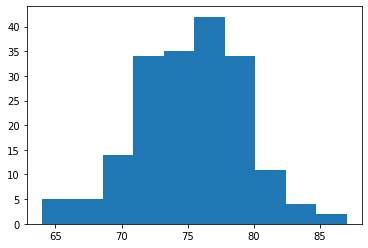

In [16]:
plt.hist(num_train_v)

(array([ 2.,  4., 11., 34., 42., 35., 34., 14.,  5.,  5.]),
 array([13. , 15.3, 17.6, 19.9, 22.2, 24.5, 26.8, 29.1, 31.4, 33.7, 36. ]),
 <a list of 10 Patch objects>)

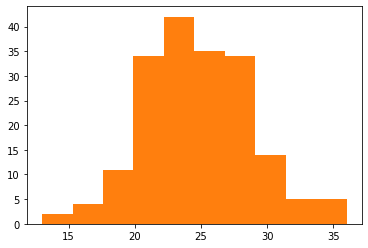

In [17]:
plt.hist(num_test_v, color='C1')

In [18]:
train_err = np.where(np.isclose(train_v,0), 0, (train_v.T-CSN_prepared_B['Viability Fraction '].values).T)

avg_train_err = non_zero_mean(train_err, axis=1) 
rms_train_err = np.sqrt(non_zero_mean(train_err**2, axis=1))
std_train_err = non_zero_std(train_err, axis=1)/np.sqrt(num_train_v) #standard errors

avg_train_v = non_zero_mean(train_v, axis=1) 
std_train_v = non_zero_std(train_v, axis=1)/np.sqrt(num_train_v) #standard errors

test_err = np.where(np.isclose(test_v,0), 0, (test_v.T-CSN_prepared_B['Viability Fraction '].values).T)

print('mae', non_zero_mean(np.abs(test_err)))

avg_test_err = non_zero_mean(test_err, axis=1)
rms_test_err = np.sqrt(non_zero_mean(test_err**2, axis=1))
std_test_err = non_zero_std(test_err, axis=1)/np.sqrt(num_test_v) #standard errors

avg_test_v = non_zero_mean(test_v, axis=1)
std_test_v = non_zero_std(test_v, axis=1)/np.sqrt(num_test_v) #standard errors

mae 0.22506169660263556


/Users/ravithree/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:58: RuntimeWarning: Mean of empty slice
/Users/ravithree/Library/Python/3.7/lib/python/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


mae 0.18817326396377113


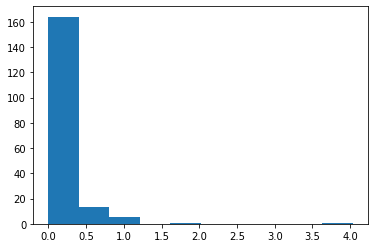

In [19]:
#def non_zero_mean(a, axis=None):
#    return np.nanmean(np.where(np.isclose(a,0), np.nan, a), axis=axis)

#avg_train_v = non_zero_mean(train_v, axis=1) 

plt.hist(np.abs(avg_test_err))

print('mae', non_zero_mean(np.abs(avg_test_err)))



train 0.0
test 0.0
LinregressResult(slope=nan, intercept=nan, rvalue=nan, pvalue=nan, stderr=nan)


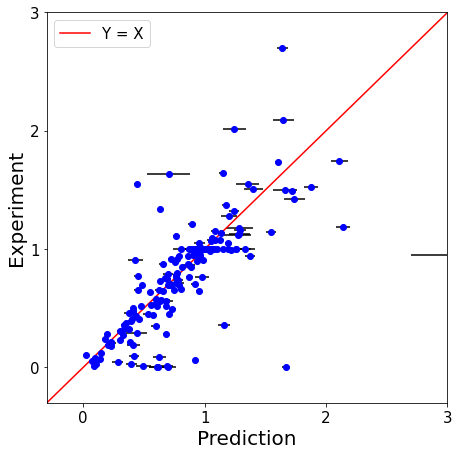

<Figure size 432x288 with 0 Axes>

In [20]:
print('train', rc(avg_train_v, CSN_prepared_B['Viability Fraction ']))
print('test', rc(avg_test_v, CSN_prepared_B['Viability Fraction ']))

print(stats.linregress(avg_test_v, CSN_prepared_B['Viability Fraction ']))
m, b = sp.stats.linregress(avg_test_v, CSN_prepared_B['Viability Fraction '])[0:2]

ann_pred_avg = plt.figure(figsize=(7.18, 7.18))
#plt.errorbar(avg_train_v, CSN_prepared['Viability Fraction '], xerr=std_train_err, 
#        fmt='o', color='b', label='Train', markersize=10)
plt.errorbar(avg_test_v, CSN_prepared_B['Viability Fraction '], xerr=std_test_err, 
        fmt='o', color='b', label=None, ecolor='k')
plt.plot((-1, 4), (-1, 4), 'r', label='Y = X')
plt.legend(fontsize=15)
plt.xlabel('Prediction', fontsize=20)
plt.ylabel('Experiment', fontsize=20)
plt.xticks(np.linspace(0, 3, 4), fontsize=15)
plt.yticks(np.linspace(0, 3, 4), fontsize=15)
plt.ylim(-0.3, 3)
plt.xlim(-0.3, 3)
plt.show()

plt.draw()
#ann_pred_avg.savefig('Figures/ann_pred_avg.eps', format='eps')

In [58]:
#rewriting code to be better and smarter
#goal - train a large number of machines with 1:3 splits of the data
#have them predict on ALL the data
#save the results separated into train and test

modelnum = 100

train_v = np.zeros((CSN_prepared_B.shape[0], modelnum))
num_train_v = np.zeros((CSN_prepared_B.shape[0]))
test_v = np.zeros((CSN_test.shape[0], modelnum))
num_test_v = np.zeros((CSN_test.shape[0]))

start_time = time.time()

for i in range(modelnum):
        
    train = CSN_prepared_B.sample(frac=3/4, random_state=i)
    test = CSN_test#CSN_prepared.loc[~CSN_prepared.index.isin(train.index), :]
    
    train_index = train.index
    test_index = test.reset_index(drop=True).index
    
    train_f = train.drop(['Viability Fraction '], axis=1)
    test_f = test.drop(['Viability Fraction '], axis=1)
    
    ntrain_f = norm(train_f, train_f)
    ntrain_l = train['Viability Fraction ']
    ntest_f = norm(test_f, train_f)
    ntest_l = test['Viability Fraction ']
    
    nall_f = norm(CSN_test.drop(['Viability Fraction '], axis=1), train_f)
    
    tf.keras.backend.clear_session()
    np.random.seed(i)
    tf.random.set_seed(i)
    model = build_model(ntrain_f)
    
    history = model.fit(ntrain_f,
    ntrain_l,
    #checsamping validation data after each epoch
    #validation_data=(ntest_f, ntest_l),
    epochs=1000,
    batch_size=25,
    verbose = 0
    )
    
    pred = model.predict(nall_f).flatten()
    
#    train_v[train_index, i] += pred[train_index] 
#    num_train_v[train_index] += 1
    test_v[test_index, i] += pred[test_index] 
    num_test_v[test_index] += 1
    
    elapsed_time = time.time() - start_time
    print(i, elapsed_time)

0 4.114699602127075
1 8.079940795898438
2 12.063406705856323
3 16.090423822402954
4 20.067869901657104
5 24.138187646865845
6 28.43193483352661
7 32.46016788482666
8 36.58083200454712
9 40.557286739349365
10 44.531649589538574
11 48.565502882003784
12 52.56524062156677
13 56.59269881248474
14 60.76053190231323
15 64.77841091156006
16 68.75946974754333
17 72.7036337852478
18 76.69896292686462
19 80.69113278388977
20 84.70584774017334
21 88.80535292625427
22 92.81698989868164
23 96.84546279907227
24 100.90947580337524
25 104.91392993927002
26 108.87719869613647
27 112.92102074623108
28 117.06063675880432
29 121.03945875167847
30 125.02775883674622
31 128.990877866745
32 132.9945206642151
33 136.98577880859375
34 140.95254683494568
35 145.08785271644592
36 149.03924298286438
37 152.98411679267883
38 156.94919872283936
39 160.90617179870605
40 164.87298464775085
41 168.8813648223877
42 172.907301902771
43 177.07971668243408
44 181.10197472572327
45 185.09465670585632
46 189.06728768348694


In [59]:
#writing these values to a file
np.savetxt('Fig/test_set_trainL.dat', train_v)
np.savetxt('Fig/test_set_train_numL.dat', num_train_v)
np.savetxt('Fig/test_set_testL.dat', test_v)
np.savetxt('Fig/test_set_test_numL.dat', num_test_v)

In [60]:
#train_v = np.loadtxt('Figures/residuals_train.dat')
#num_train_v = np.loadtxt('Figures/residuals_train_num.dat')
test_v = np.loadtxt('Fig/test_set_testL.dat')
num_test_v = np.loadtxt('Fig/test_set_test_numL.dat')

In [61]:
train_err = np.where(np.isclose(train_v,0), 0, (train_v.T-CSN_prepared_B['Viability Fraction '].values).T)

avg_train_err = non_zero_mean(train_err, axis=1) 
rms_train_err = np.sqrt(non_zero_mean(train_err**2, axis=1))
std_train_err = non_zero_std(train_err, axis=1)/np.sqrt(num_train_v) #standard errors

avg_train_v = non_zero_mean(train_v, axis=1) 
std_train_v = non_zero_std(train_v, axis=1)/np.sqrt(num_train_v) #standard errors

test_err = np.where(np.isclose(test_v,0), 0, (test_v.T-CSN_test['Viability Fraction '].values).T)

print('mae', non_zero_mean(np.abs(test_err)))

avg_test_err = non_zero_mean(test_err, axis=1)
rms_test_err = np.sqrt(non_zero_mean(test_err**2, axis=1))
std_test_err = non_zero_std(test_err, axis=1)/np.sqrt(num_test_v) #standard errors

avg_test_v = non_zero_mean(test_v, axis=1)
avg_test_v4 = avg_test_v 
std_test_v = non_zero_std(test_v, axis=1)/np.sqrt(num_test_v) #standard errors

mae 0.22891870678969306


/Users/ravithree/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:58: RuntimeWarning: Mean of empty slice
/Users/ravithree/Library/Python/3.7/lib/python/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


In [62]:
np.max(std_test_err)

0.05430299486115199

train 0.0
test 0.7074197541515301
LinregressResult(slope=0.8030366863022222, intercept=0.18556522182885837, rvalue=0.6720487664439533, pvalue=0.0011720194086261304, stderr=0.20855828633836446)


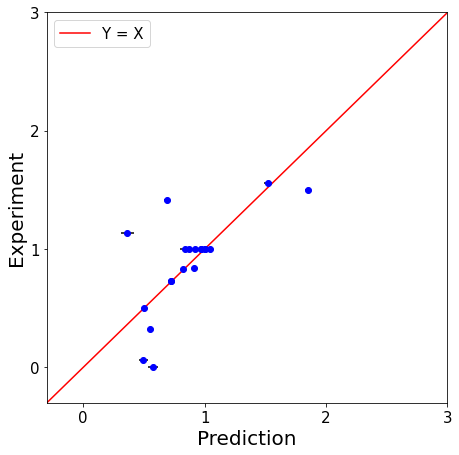

<Figure size 432x288 with 0 Axes>

In [26]:
print('train', rc(avg_train_v, CSN_prepared_B['Viability Fraction ']))
print('test', rc(avg_test_v, CSN_test['Viability Fraction ']))

print(stats.linregress(avg_test_v, CSN_test['Viability Fraction ']))
m, b = sp.stats.linregress(avg_test_v, CSN_test['Viability Fraction '])[0:2]

ann_pred_avg = plt.figure(figsize=(7.18, 7.18))
#plt.errorbar(avg_train_v, CSN_prepared['Viability Fraction '], xerr=std_train_err, 
#        fmt='o', color='b', label='Train', markersize=10)
plt.errorbar(avg_test_v, CSN_test['Viability Fraction '], xerr=std_test_err, 
        fmt='o', color='b', label=None, ecolor='k')
plt.plot((-1, 4), (-1, 4), 'r', label='Y = X')
plt.legend(fontsize=15)
plt.xlabel('Prediction', fontsize=20)
plt.ylabel('Experiment', fontsize=20)
plt.xticks(np.linspace(0, 3, 4), fontsize=15)
plt.yticks(np.linspace(0, 3, 4), fontsize=15)
plt.ylim(-0.3, 3)
plt.xlim(-0.3, 3)
plt.show()

plt.draw()
#ann_pred_avg.savefig('Figures/ann_pred_avg.eps', format='eps')

train 0.0
test 0.7074197541515301
LinregressResult(slope=0.8030366863022222, intercept=0.18556522182885837, rvalue=0.6720487664439533, pvalue=0.0011720194086261304, stderr=0.20855828633836446)


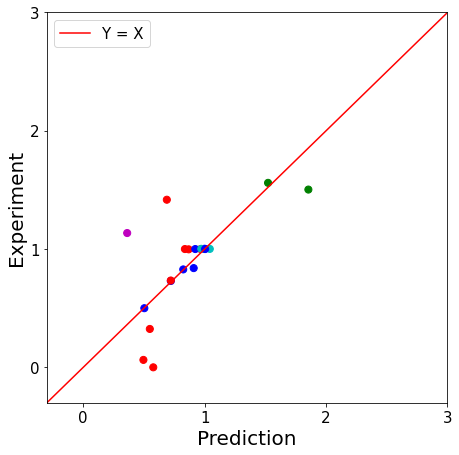

<Figure size 432x288 with 0 Axes>

In [63]:
categories = np.array([0, 0, 1, 2, 0, 2, 3, 0, 0, 0, 2, 2, 0, 1, 2, 0, 3, 4, 2, 2])
colormap = np.array(['r', 'g', 'b', 'c', 'm'])

print('train', rc(avg_train_v, CSN_prepared_B['Viability Fraction ']))
print('test', rc(avg_test_v, CSN_test['Viability Fraction ']))

print(stats.linregress(avg_test_v, CSN_test['Viability Fraction ']))
m, b = sp.stats.linregress(avg_test_v, CSN_test['Viability Fraction '])[0:2]

ann_pred_avg = plt.figure(figsize=(7.18, 7.18))
#plt.errorbar(avg_train_v, CSN_prepared['Viability Fraction '], xerr=std_train_err, 
#        fmt='o', color='b', label='Train', markersize=10)

plt.scatter(avg_test_v, CSN_test['Viability Fraction '], s=50, c=colormap[categories])
#plt.errorbar(avg_test_v, CSN_test['Viability Fraction '], xerr=std_test_err, 
#        fmt='o', color='b', label=None, ecolor='k')
plt.plot((-1, 4), (-1, 4), 'r', label='Y = X')
plt.legend(fontsize=15)
plt.xlabel('Prediction', fontsize=20)
plt.ylabel('Experiment', fontsize=20)
plt.xticks(np.linspace(0, 3, 4), fontsize=15)
plt.yticks(np.linspace(0, 3, 4), fontsize=15)
plt.ylim(-0.3, 3)
plt.xlim(-0.3, 3)
plt.show()

plt.draw()
#ann_pred_avg.savefig('Figures/ann_pred_avg.eps', format='eps')

In [28]:
#########206-T18

In [29]:
#CSN_path = './'
CSN_path = './Data/'

def load_CSN_data():
    csv_path = CSN_path + "Master_List_LCPLCP.csv"
    return pd.read_csv(csv_path)

CSN = load_CSN_data()

CSN_new_err = CSN['Error'][-18:]

CSN = CSN.drop(['Example ID', 'Source', 'Figure ID', 'Data Provider', 'PI',
       'Date Received', 'Data Measurment Published', 'Prior Exposure', 'Comments', 'Error'], axis=1)

tsize = CSN.shape[0]//10

CSN_new = pd.get_dummies(CSN)

CSN_new['Surface Area per Liter'] = CSN_new['Surface Area (NMC) (m2/g)'] * CSN_new['Concentration (mg/L)']
CSN_new = CSN_new.drop(['Surface Area (NMC) (m2/g)'], axis=1)

CSN_new['log Concentration'] = np.log10(CSN_new['Concentration (mg/L)'] + 1e-9)
CSN_new = CSN_new.drop(['Concentration (mg/L)'], axis=1)

CSN_new_A = CSN_new[-18:] #assign the last 18 examples for 18 test cases for a different array

CSN_prepared_B = CSN_new[:-18] # Removing the last 18 
CSN_hold_1 = sklearn.utils.shuffle(CSN_prepared_B, random_state=5946) #shuffling the 206 data examples as Clyde did
#tsize1 = CSN_hold_1.shape[0]//10 # decide the size of the test examples which is 20 - clyde did it

#CSN_prepared_B = CSN_hold_1[:-tsize1].reset_index(drop=True) #Remove that 20 data examples from the bottom of the list
#CSN_test = CSN_hold_1[-tsize1:] # assign that 20 data examples whcih we will use later

In [30]:
def norm(x, train_dataset):
    train_stats = train_dataset.describe().transpose()
    return (x - train_stats['mean']) / train_stats['std'].replace(to_replace=0, value=1)

def build_model(data):
    model = keras.Sequential()
    model.add(keras.layers.Dense(5, activation=keras.layers.ELU(), input_shape=(data.shape[1],)))
    for k in range(3-1):
        model.add(keras.layers.Dense(5, activation=keras.layers.ELU()))
    model.add(keras.layers.Dense(1, activation=keras.layers.ReLU()))
    
    model.compile(loss='mse',
                optimizer=keras.optimizers.Adam(),
                metrics=['mae'])
    
    return model

def plot_mae(history):
    plt.figure()
    plt.xlabel('Training Steps')
    plt.ylabel('Mean Abs Error')
    plt.ylim(0, 1)
    plt.plot(history.epoch, np.array(history.history['mae']),
             label='Train MAE')
    plt.plot(history.epoch, np.array(history.history['val_mae']),
             label = 'Val MAE')
    plt.legend()
    plt.show()
    print(np.array(history.history['mae'])[-1], 
        np.array(history.history['val_mae'])[-1])
    
def plot_loss(history):
    plt.figure()
    plt.xlabel('Training Steps')
    plt.ylabel('Loss')
    plt.ylim(0, 1)
    plt.plot(history.epoch, np.array(history.history['loss']),
             label='Train MAE')
    plt.plot(history.epoch, np.array(history.history['val_loss']),
             label = 'Val MAE')
    plt.legend()
    plt.show()
    print(np.array(history.history['loss'])[-1], 
        np.array(history.history['val_loss'])[-1])
    
def rc(x, y):
    mx = np.mean(x)
    my = np.mean(y)
    sx = np.std(x)
    sy = np.std(y)
    
    zx = (x - mx)/sx
    zy = (y - my)/sy
    
    return np.sum(zx*zy)/(x.size-1)

def non_zero_mean(a, axis=None):
    return np.nanmean(np.where(np.isclose(a,0), np.nan, a), axis=axis)

def non_zero_std(a, axis=None):
    return np.nanstd(np.where(np.isclose(a,0), np.nan, a), axis=axis)

def print_full(x):
    pd.set_option('display.max_rows', x.shape[0])
    if len(x.shape) < 2:
        pd.set_option('display.max_columns', 1)
    else:
        pd.set_option('display.max_columns', x.shape[1])
    return x
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')

In [31]:
#rewriting code to be better and smarter
#goal - train a large number of machines with 1:3 splits of the data
#have them predict on ALL the data
#save the results separated into train and test

modelnum = 100

train_v = np.zeros((CSN_hold_1.shape[0], modelnum))
num_train_v = np.zeros((CSN_hold_1.shape[0]))
test_v = np.zeros((CSN_new_A.shape[0], modelnum))
num_test_v = np.zeros((CSN_new_A.shape[0]))

start_time = time.time()

for i in range(modelnum):
        
    train = CSN_hold_1.sample(frac=3/4, random_state=i)
    test = CSN_new_A#CSN_prepared.loc[~CSN_prepared.index.isin(train.index), :]
    
    train_index = train.index
    test_index = test.reset_index(drop=True).index
    
    train_f = train.drop(['Viability Fraction '], axis=1)
    test_f = test.drop(['Viability Fraction '], axis=1)
    
    ntrain_f = norm(train_f, train_f)
    ntrain_l = train['Viability Fraction ']
    ntest_f = norm(test_f, train_f)
    ntest_l = test['Viability Fraction ']
    
    nall_f = norm(CSN_new_A.drop(['Viability Fraction '], axis=1), train_f)
    
    tf.keras.backend.clear_session()
    np.random.seed(i)
    tf.random.set_seed(i)
    model = build_model(ntrain_f)
    
    history = model.fit(ntrain_f,
    ntrain_l,
    #checsamping validation data after each epoch
    #validation_data=(ntest_f, ntest_l),
    epochs=1000,
    batch_size=25,
    verbose = 0
    )
    
    pred = model.predict(nall_f).flatten()
    
#    train_v[train_index, i] += pred[train_index] 
#    num_train_v[train_index] += 1
    test_v[test_index, i] += pred[test_index] 
    num_test_v[test_index] += 1
    
    elapsed_time = time.time() - start_time
    print(i, elapsed_time)

0 4.450984954833984
1 8.863335132598877
2 13.25437617301941
3 17.635178804397583
4 22.16876196861267
5 26.67539095878601
6 31.084301948547363
7 35.4661819934845
8 39.88838601112366
9 44.28279495239258
10 48.8535430431366
11 53.257806062698364
12 57.603262186050415
13 62.020262002944946
14 66.38710808753967
15 70.77683997154236
16 75.14730882644653
17 79.82273387908936
18 84.39999890327454
19 88.94429779052734
20 93.3418960571289
21 97.74894094467163
22 102.2822470664978
23 106.91443395614624
24 111.49909806251526
25 115.89080691337585
26 120.22823691368103
27 124.59487986564636
28 128.97530579566956
29 133.3914430141449
30 137.8097848892212
31 142.3707070350647
32 146.8308379650116
33 151.23180413246155
34 155.6472098827362
35 160.00825214385986
36 164.40582013130188
37 168.75519490242004
38 173.15264797210693
39 177.7189610004425
40 182.09904503822327
41 186.54790210723877
42 190.97573685646057
43 195.40082383155823
44 199.8100390434265
45 204.2910509109497
46 208.6814000606537
47 213

In [32]:
#writing these values to a file
np.savetxt('Fig/test_set_train206L.dat', train_v)
np.savetxt('Fig/test_set_train_num206L.dat', num_train_v)
np.savetxt('Fig/test_set_test206L.dat', test_v)
np.savetxt('Fig/test_set_test_num206L.dat', num_test_v)

In [33]:
#train_v = np.loadtxt('Figures/residuals_train.dat')
#num_train_v = np.loadtxt('Figures/residuals_train_num.dat')
test_v = np.loadtxt('Fig/test_set_test206L.dat')
num_test_v = np.loadtxt('Fig/test_set_test_num206L.dat')

In [34]:
train_err = np.where(np.isclose(train_v,0), 0, (train_v.T-CSN_hold_1['Viability Fraction '].values).T)

avg_train_err = non_zero_mean(train_err, axis=1) 
rms_train_err = np.sqrt(non_zero_mean(train_err**2, axis=1))
std_train_err = non_zero_std(train_err, axis=1)/np.sqrt(num_train_v) #standard errors

avg_train_v = non_zero_mean(train_v, axis=1) 
std_train_v = non_zero_std(train_v, axis=1)/np.sqrt(num_train_v) #standard errors

test_err = np.where(np.isclose(test_v,0), 0, (test_v.T-CSN_new_A['Viability Fraction '].values).T)

print('mae', non_zero_mean(np.abs(test_err)))

avg_test_err = non_zero_mean(test_err, axis=1)
rms_test_err = np.sqrt(non_zero_mean(test_err**2, axis=1))
std_test_err = non_zero_std(test_err, axis=1)/np.sqrt(num_test_v) #standard errors

avg_test_v = non_zero_mean(test_v, axis=1)
avg_test_v2 = avg_test_v
std_test_v = non_zero_std(test_v, axis=1)/np.sqrt(num_test_v) #standard errors

mae 0.5530375118594844


/Users/ravithree/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:58: RuntimeWarning: Mean of empty slice
/Users/ravithree/Library/Python/3.7/lib/python/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


In [35]:
np.max(std_test_err)

0.05867481288715983

train 0.0
test 0.4157758595239932
LinregressResult(slope=1.6289543700391143, intercept=-0.8884992860322997, rvalue=0.3926772006615492, pvalue=0.10698180304503159, stderr=0.9537801220921222)


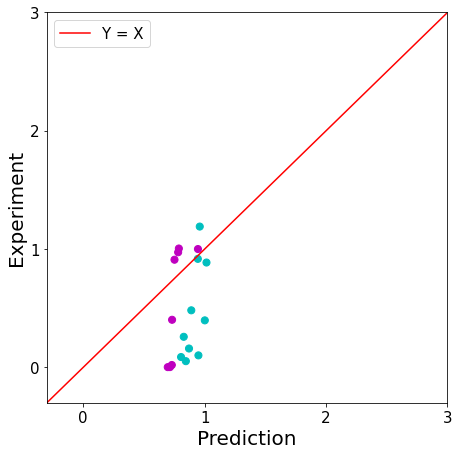

<Figure size 432x288 with 0 Axes>

In [36]:
categories = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1])
colormap = np.array(['c', 'm'])

print('train', rc(avg_train_v, CSN_hold_1['Viability Fraction ']))
print('test', rc(avg_test_v, CSN_new_A['Viability Fraction ']))

print(stats.linregress(avg_test_v, CSN_new_A['Viability Fraction ']))
m, b = sp.stats.linregress(avg_test_v, CSN_new_A['Viability Fraction '])[0:2]

ann_pred_avg = plt.figure(figsize=(7.18, 7.18))
#plt.errorbar(avg_train_v, CSN_prepared['Viability Fraction '], xerr=std_train_err, 
#        fmt='o', color='b', label='Train', markersize=10)
plt.scatter(avg_test_v, CSN_new_A['Viability Fraction '], s=50, c=colormap[categories])
#plt.errorbar(avg_test_v, CSN_new_A['Viability Fraction '], xerr=std_test_err, 
#       fmt='o', color='b', label=None, ecolor='k')
plt.plot((-1, 4), (-1, 4), 'r', label='Y = X')
plt.legend(fontsize=15)
plt.xlabel('Prediction', fontsize=20)
plt.ylabel('Experiment', fontsize=20)
plt.xticks(np.linspace(0, 3, 4), fontsize=15)
plt.yticks(np.linspace(0, 3, 4), fontsize=15)
plt.ylim(-0.3, 3)
plt.xlim(-0.3, 3)
plt.show()

plt.draw()

In [37]:
######186-T18

In [38]:
#CSN_path = './'
CSN_path = './Data/'

def load_CSN_data():
    csv_path = CSN_path + "Master_List_LCPLCP.csv"
    return pd.read_csv(csv_path)

CSN = load_CSN_data()

CSN_new_err = CSN['Error'][-18:]

CSN = CSN.drop(['Example ID', 'Source', 'Figure ID', 'Data Provider', 'PI',
       'Date Received', 'Data Measurment Published', 'Prior Exposure', 'Comments', 'Error'], axis=1)

tsize = CSN.shape[0]//10

CSN_new = pd.get_dummies(CSN)

CSN_new['Surface Area per Liter'] = CSN_new['Surface Area (NMC) (m2/g)'] * CSN_new['Concentration (mg/L)']
CSN_new = CSN_new.drop(['Surface Area (NMC) (m2/g)'], axis=1)

CSN_new['log Concentration'] = np.log10(CSN_new['Concentration (mg/L)'] + 1e-9)
CSN_new = CSN_new.drop(['Concentration (mg/L)'], axis=1)

CSN_new_A = CSN_new[-18:] #assign the last 18 examples for 18 test cases for a different array

CSN_prepared_B = CSN_new[:-18] # Removing the last 18 
CSN_hold_1 = sklearn.utils.shuffle(CSN_prepared_B, random_state=5946) #shuffling the 206 data examples as Clyde did
tsize1 = CSN_hold_1.shape[0]//10 # decide the size of the test examples which is 20 - clyde did it

CSN_prepared_B = CSN_hold_1[:-tsize1].reset_index(drop=True) #Remove that 20 data examples from the bottom of the list
CSN_test = CSN_hold_1[-tsize1:] # assign that 20 data examples whcih we will use later

In [39]:
def norm(x, train_dataset):
    train_stats = train_dataset.describe().transpose()
    return (x - train_stats['mean']) / train_stats['std'].replace(to_replace=0, value=1)

def build_model(data):
    model = keras.Sequential()
    model.add(keras.layers.Dense(5, activation=keras.layers.ELU(), input_shape=(data.shape[1],)))
    for k in range(3-1):
        model.add(keras.layers.Dense(5, activation=keras.layers.ELU()))
    model.add(keras.layers.Dense(1, activation=keras.layers.ReLU()))
    
    model.compile(loss='mse',
                optimizer=keras.optimizers.Adam(),
                metrics=['mae'])
    
    return model

def plot_mae(history):
    plt.figure()
    plt.xlabel('Training Steps')
    plt.ylabel('Mean Abs Error')
    plt.ylim(0, 1)
    plt.plot(history.epoch, np.array(history.history['mae']),
             label='Train MAE')
    plt.plot(history.epoch, np.array(history.history['val_mae']),
             label = 'Val MAE')
    plt.legend()
    plt.show()
    print(np.array(history.history['mae'])[-1], 
        np.array(history.history['val_mae'])[-1])
    
def plot_loss(history):
    plt.figure()
    plt.xlabel('Training Steps')
    plt.ylabel('Loss')
    plt.ylim(0, 1)
    plt.plot(history.epoch, np.array(history.history['loss']),
             label='Train MAE')
    plt.plot(history.epoch, np.array(history.history['val_loss']),
             label = 'Val MAE')
    plt.legend()
    plt.show()
    print(np.array(history.history['loss'])[-1], 
        np.array(history.history['val_loss'])[-1])
    
def rc(x, y):
    mx = np.mean(x)
    my = np.mean(y)
    sx = np.std(x)
    sy = np.std(y)
    
    zx = (x - mx)/sx
    zy = (y - my)/sy
    
    return np.sum(zx*zy)/(x.size-1)

def non_zero_mean(a, axis=None):
    return np.nanmean(np.where(np.isclose(a,0), np.nan, a), axis=axis)

def non_zero_std(a, axis=None):
    return np.nanstd(np.where(np.isclose(a,0), np.nan, a), axis=axis)

def print_full(x):
    pd.set_option('display.max_rows', x.shape[0])
    if len(x.shape) < 2:
        pd.set_option('display.max_columns', 1)
    else:
        pd.set_option('display.max_columns', x.shape[1])
    return x
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')

In [40]:
#rewriting code to be better and smarter
#goal - train a large number of machines with 1:3 splits of the data
#have them predict on ALL the data
#save the results separated into train and test

modelnum = 100

train_v = np.zeros((CSN_prepared_B.shape[0], modelnum))
num_train_v = np.zeros((CSN_prepared_B.shape[0]))
test_v = np.zeros((CSN_new_A.shape[0], modelnum))
num_test_v = np.zeros((CSN_new_A.shape[0]))

start_time = time.time()

for i in range(modelnum):
        
    train = CSN_prepared_B.sample(frac=3/4, random_state=i)
    test = CSN_new_A#CSN_prepared.loc[~CSN_prepared.index.isin(train.index), :]
    
    train_index = train.index
    test_index = test.reset_index(drop=True).index
    
    train_f = train.drop(['Viability Fraction '], axis=1)
    test_f = test.drop(['Viability Fraction '], axis=1)
    
    ntrain_f = norm(train_f, train_f)
    ntrain_l = train['Viability Fraction ']
    ntest_f = norm(test_f, train_f)
    ntest_l = test['Viability Fraction ']
    
    nall_f = norm(CSN_new_A.drop(['Viability Fraction '], axis=1), train_f)
    
    tf.keras.backend.clear_session()
    np.random.seed(i)
    tf.random.set_seed(i)
    model = build_model(ntrain_f)
    
    history = model.fit(ntrain_f,
    ntrain_l,
    #checsamping validation data after each epoch
    #validation_data=(ntest_f, ntest_l),
    epochs=1000,
    batch_size=25,
    verbose = 0
    )
    
    pred = model.predict(nall_f).flatten()
    
#    train_v[train_index, i] += pred[train_index] 
#    num_train_v[train_index] += 1
    test_v[test_index, i] += pred[test_index] 
    num_test_v[test_index] += 1
    
    elapsed_time = time.time() - start_time
    print(i, elapsed_time)

0 4.010433912277222
1 8.163136005401611
2 12.13158392906189
3 16.156137943267822
4 20.167938947677612
5 24.165604829788208
6 28.188788890838623
7 32.22089076042175
8 36.345803022384644
9 40.34899878501892
10 44.35698103904724
11 48.32336902618408
12 52.318033933639526
13 56.33901000022888
14 60.41740393638611
15 64.56793689727783
16 68.55536413192749
17 72.50986909866333
18 76.46981978416443
19 80.45065593719482
20 84.40144991874695
21 88.37338399887085
22 92.59633684158325
23 96.61344313621521
24 100.64926099777222
25 104.67074084281921
26 108.65378499031067
27 112.62193202972412
28 116.64159989356995
29 120.81157398223877
30 124.78671479225159
31 128.80052995681763
32 132.83406686782837
33 136.86989903450012
34 140.88730382919312
35 144.8356339931488
36 148.83255815505981
37 153.00493216514587
38 156.96676206588745
39 160.9908049106598
40 165.03152418136597
41 169.06279397010803
42 173.07172083854675
43 177.24391794204712
44 181.28219294548035
45 185.28390502929688
46 189.29948115348

In [41]:
#writing these values to a file
np.savetxt('Fig/test_set_train186-18L.dat', train_v)
np.savetxt('Fig/test_set_train_num186-18L.dat', num_train_v)
np.savetxt('Fig/test_set_test186-18L.dat', test_v)
np.savetxt('Fig/test_set_test_num186-18L.dat', num_test_v)

In [42]:
#train_v = np.loadtxt('Figures/residuals_train.dat')
#num_train_v = np.loadtxt('Figures/residuals_train_num.dat')
test_v = np.loadtxt('Fig/test_set_test186-18L.dat')
num_test_v = np.loadtxt('Fig/test_set_test_num186-18L.dat')

In [43]:
train_err = np.where(np.isclose(train_v,0), 0, (train_v.T-CSN_prepared_B['Viability Fraction '].values).T)

avg_train_err = non_zero_mean(train_err, axis=1) 
rms_train_err = np.sqrt(non_zero_mean(train_err**2, axis=1))
std_train_err = non_zero_std(train_err, axis=1)/np.sqrt(num_train_v) #standard errors

avg_train_v = non_zero_mean(train_v, axis=1) 
std_train_v = non_zero_std(train_v, axis=1)/np.sqrt(num_train_v) #standard errors

test_err = np.where(np.isclose(test_v,0), 0, (test_v.T-CSN_new_A['Viability Fraction '].values).T)

print('mae', non_zero_mean(np.abs(test_err)))

avg_test_err = non_zero_mean(test_err, axis=1)
rms_test_err = np.sqrt(non_zero_mean(test_err**2, axis=1))
std_test_err = non_zero_std(test_err, axis=1)/np.sqrt(num_test_v) #standard errors

avg_test_v = non_zero_mean(test_v, axis=1)
avg_test_v3 = avg_test_v
std_test_v = non_zero_std(test_v, axis=1)/np.sqrt(num_test_v) #standard errors

mae 0.6423439952028364


/Users/ravithree/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:58: RuntimeWarning: Mean of empty slice
/Users/ravithree/Library/Python/3.7/lib/python/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


In [44]:
np.max(std_test_err)

0.0662033715091814

train 0.0
test 0.12198546628041906
LinregressResult(slope=0.3261049390282211, intercept=0.17446704585037198, rvalue=0.11520849593150687, pvalue=0.6489520122180843, stderr=0.7029288768730918)


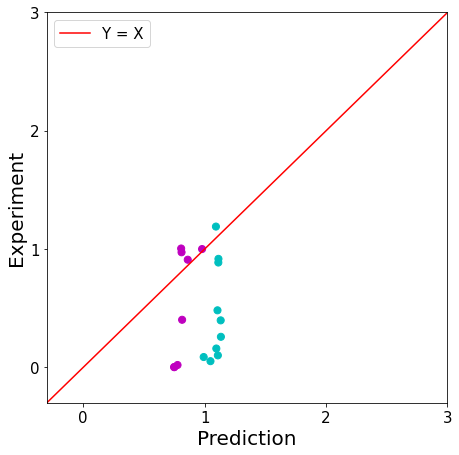

<Figure size 432x288 with 0 Axes>

In [48]:
categories = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1])
colormap = np.array(['c', 'm'])

print('train', rc(avg_train_v, CSN_prepared_B['Viability Fraction ']))
print('test', rc(avg_test_v, CSN_new_A['Viability Fraction ']))

print(stats.linregress(avg_test_v, CSN_new_A['Viability Fraction ']))
m, b = sp.stats.linregress(avg_test_v, CSN_new_A['Viability Fraction '])[0:2]

ann_pred_avg = plt.figure(figsize=(7.18, 7.18))
#plt.errorbar(avg_train_v, CSN_prepared['Viability Fraction '], xerr=std_train_err, 
#        fmt='o', color='b', label='Train', markersize=10)
plt.scatter(avg_test_v, CSN_new_A['Viability Fraction '], s=50, c=colormap[categories])
#plt.errorbar(avg_test_v, CSN_new_A['Viability Fraction '], xerr=std_test_err, 
#       fmt='o', color='b', label=None, ecolor='k')
plt.plot((-1, 4), (-1, 4), 'r', label='Y = X')
plt.legend(fontsize=15)
plt.xlabel('Prediction', fontsize=20)
plt.ylabel('Experiment', fontsize=20)
plt.xticks(np.linspace(0, 3, 4), fontsize=15)
plt.yticks(np.linspace(0, 3, 4), fontsize=15)
plt.ylim(-0.3, 3)
plt.xlim(-0.3, 3)
plt.show()

plt.draw()

In [46]:
#####This is the stacked plot

[0.57672206 0.83732246 1.85430629 0.8235691  0.49562484 0.99958288
 1.04227468 0.54833955 0.96684343 0.86834924 0.90971167 0.72150066
 0.68842179 1.52216868 0.92280413 0.72114488 0.9721611  0.36180441
 1.00364402 0.5031477 ]
100   0.00000
91    1.00000
111   1.50284
47    0.82776
82    0.06271
53    1.00261
147   1.00115
74    0.32440
79    1.00000
64    0.99750
48    0.83884
160   0.73000
66    1.41700
114   1.55962
201   1.00000
28    0.73400
149   1.00191
5     1.13533
198   1.00000
17    0.49984
Name: Viability Fraction , dtype: float64
[0.95959623 1.01503933 1.00134546 0.94868754 0.84512316 0.94379533
 0.88990104 0.82775709 0.87112928 0.80563697 0.94477344 0.78164655
 0.78747084 0.75162931 0.73166938 0.72957404 0.71441585 0.69614266]
206   1.19000
207   0.88600
208   0.39700
209   0.10100
210   0.05200
211   0.91700
212   0.48200
213   0.25800
214   0.15900
215   0.08700
216   1.00000
217   0.97266
218   1.00455
219   0.90976
220   0.40187
221   0.01958
222   0.00191
223   0.00163

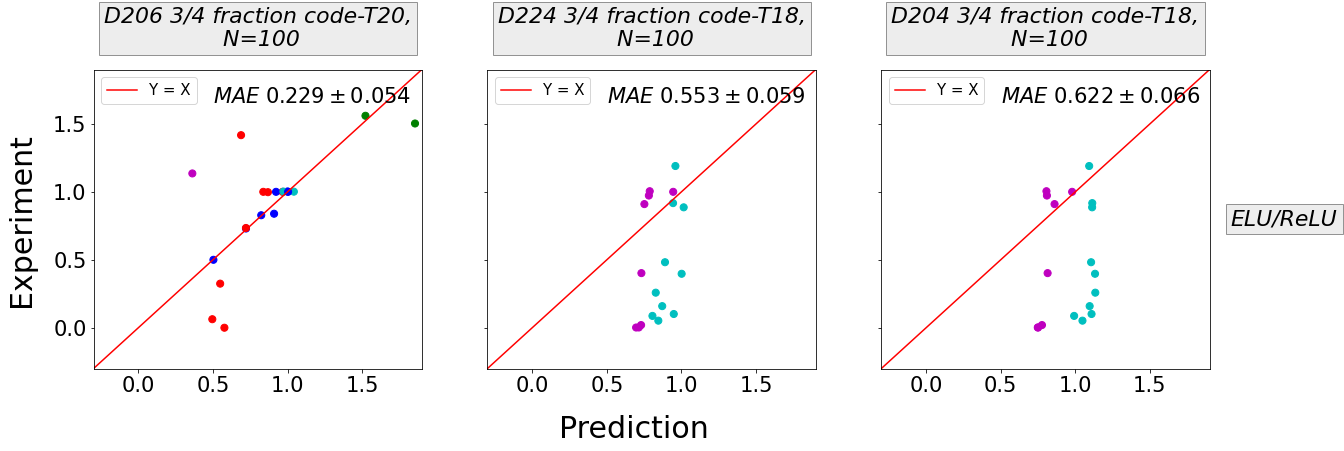

In [158]:
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(20, 5.5))


fig.text(0.5, -0.05, 'Prediction', ha='center', fontsize=30)
fig.text(0.065, 0.5, 'Experiment', va='center', rotation='vertical', fontsize=30)

plt.rc('xtick', labelsize=21)

plt.rc('ytick', labelsize=21)

categories = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1])
colormap = np.array(['c', 'm'])

categories1 = np.array([0, 0, 1, 2, 0, 2, 3, 0, 0, 0, 2, 2, 0, 1, 2, 0, 3, 4, 2, 2])
colormap1 = np.array(['r', 'g', 'b', 'c', 'm'])

print (avg_test_v4)
print (CSN_test['Viability Fraction '])

axs[0].scatter(avg_test_v4, CSN_test['Viability Fraction '], s=50, c=colormap1[categories1])
axs[0].plot((-1, 4), (-1, 4), 'r')#, linewidth=3)
axs[0].legend(fontsize=15)


#axs[0,0].text(0.55, 1.9, 'k=1', fontsize=28, style='italic',
#        bbox={'facecolor': 'lightgrey', 'alpha': 0.4, 'pad': 5})

axs[0].text(0.8, 2.2, 'D206 3/4 fraction code-T20,\n N=100', fontsize=22, style='italic',
        bbox={'facecolor': 'lightgrey', 'alpha': 0.4, 'pad': 5}, ha='center', va='center')

axs[0].text(0.5, 1.7, r'$MAE\ 0.229\pm0.054$', fontsize=21, ha='left', va='center')

axs[0].set_ylim(-0.3, 1.9)
axs[0].set_xlim(-0.3, 1.9)


print (avg_test_v2)
print (CSN_new_A['Viability Fraction ']) 

axs[1].scatter(avg_test_v2, CSN_new_A['Viability Fraction '], s=50, c=colormap[categories])
axs[1].plot((-1, 4), (-1, 4), 'r')#, linewidth=3)
axs[1].legend(fontsize=15)


#axs[1].text(0.55, 1.9, 'k=4', fontsize=28, style='italic',
#        bbox={'facecolor': 'lightgrey', 'alpha': 0.4, 'pad': 5})

axs[1].text(0.8, 2.2, 'D224 3/4 fraction code-T18,\n N=100', fontsize=22, style='italic',
        bbox={'facecolor': 'lightgrey', 'alpha': 0.4, 'pad': 5}, ha='center', va='center')

axs[1].text(0.5, 1.7, r'$MAE\ 0.553\pm0.059$', fontsize=21, ha='left', va='center')

axs[1].set_ylim(-0.3, 1.9)
axs[1].set_xlim(-0.3, 1.9)

print (avg_test_v3)
print (CSN_new_A['Viability Fraction ']) 


axs[2].scatter(avg_test_v3, CSN_new_A['Viability Fraction '], s=50, c=colormap[categories])
axs[2].plot((-1, 4), (-1, 4), 'r')#, linewidth=3)
axs[2].legend(fontsize=15)


#axs[2].text(0.55, 1.9, 'k=7', fontsize=28, style='italic',
#        bbox={'facecolor': 'lightgrey', 'alpha': 0.4, 'pad': 5})

axs[2].text(0.8, 2.2, 'D204 3/4 fraction code-T18,\n N=100', fontsize=22, style='italic',
        bbox={'facecolor': 'lightgrey', 'alpha': 0.4, 'pad': 5}, ha='center', va='center')

axs[2].text(2.4, 0.8, 'ELU/ReLU', fontsize=22, style='italic',
        bbox={'facecolor': 'lightgrey', 'alpha': 0.4, 'pad': 5}, ha='center', va='center')

axs[2].text(0.5, 1.7, r'$MAE\ 0.622\pm0.066$', fontsize=21, ha='left', va='center')





axs[2].set_ylim(-0.3, 1.9)
axs[2].set_xlim(-0.3, 1.9)



plt.savefig('Fig11aNew.pdf', transparent=True, format='pdf', bbox_inches='tight')
#plt.savefig('Fig11a.pdf', transparent=True, format='pdf', bbox_inches='tight')